- **Handwritting numbers detection** --Neural network back-propagation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as sio
import scipy.optimize as opt
from sklearn import datasets
from sklearn.metrics import classification_report

# Load dataset

In [2]:
digits = datasets.load_digits()

In [3]:
type(digits)

sklearn.utils.Bunch

In [4]:
print('digits.keys() = ', digits.keys())

digits.keys() =  dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


- Digits is a handwritting number dataset, it is a bunch type dataset, which inherits from the dictionary class.
- Digits contains data, target, target_names, images and DESCR

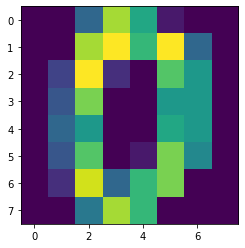

In [5]:
#plt.gray()
plt.imshow(digits.images[0])

In [6]:
print('digits.data.shape = ', digits.data.shape)
print('digits.target.shape = ', digits.target.shape)
print('digits.target = ', digits.target)
print('digits.target_names.shape = ', digits.target_names.shape)
print('digits.target_names = ', digits.target_names)
print('digits.images.shape = ', digits.images.shape)
#print('digits.images = ', digits.images)

digits.data.shape =  (1797, 64)
digits.target.shape =  (1797,)
digits.target =  [0 1 2 ... 8 9 8]
digits.target_names.shape =  (10,)
digits.target_names =  [0 1 2 3 4 5 6 7 8 9]
digits.images.shape =  (1797, 8, 8)


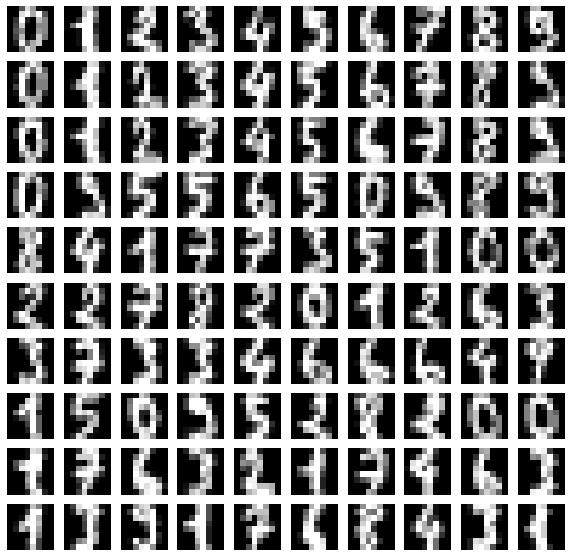

In [7]:
#check the first one hundred images
_, axes = plt.subplots(10,10,figsize = (10,10))
axes = [item for subl in axes for item in subl]

for i, ax in enumerate(axes):
    img = digits.images[i]
    ax.imshow(img, cmap="gray")
    ax.axis('off')

In [8]:
def onehot_y(y):
#     """expand 5000*1 into 5000*10
#     where y=10 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]: ndarray
#     """
    res = []
    for i in y:
        y_array = np.zeros(10)
        y_array[i - 1] = 1

        res.append(y_array)

    return np.array(res)
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder(sparse=False)
# y_onehot = encoder.fit_transform(y)
# y_onehot.shape #这个函数与expand_y(y)一致

In [9]:
y_onehot = onehot_y(digits.target)
y_onehot

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

<img style="float: left;" src="NN.png">

Thus, our neural network has an input layer that matches the size of our instance data, which have more than 64 bias units (with one extra bias unit), a hidden layer with 25 cells (26 bias units), and a output layer with 10 cells.

In [10]:
weights = sio.loadmat('ex4weights.mat')

In [11]:
theta1, theta2 = weights['Theta1'], weights['Theta2']

In [12]:
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [13]:
theta1 = theta1[:, :65]

In [14]:
theta1.shape

(25, 65)

In [15]:
def serialize(a, b):
  
    return np.concatenate((np.ravel(a), np.ravel(b)))

In [16]:
theta = serialize(theta1, theta2)

In [17]:
theta.shape

(1885,)

# Forward-propagation and cost function

## Sigmoid function

In [18]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

## Forward propagation

In [19]:
def deserialize(seq):
#     """into ndarray of (25, 65), (10, 26)"""
    return seq[:25*65].reshape(25, 65), seq[25*65:].reshape(10, 26)

In [20]:
def forward_propagation(theta, X):
    
    theta1, theta2 = deserialize(theta)
    m = X.shape[0]
    a1 = X
    
    z2 = a1 @ theta1.T
    a2 = np.insert(sigmoid(z2), 0, np.ones(m), axis=1)
    
    z3 = a2 @ theta2.T
    h = sigmoid(z3)
    
    return a1, z2, a2, z3, h

INIT_EPSILON = 0.0001

Theta1 = np.random.rand(25,65) * (2 * INIT_EPSILON) - INIT_EPSILON
Theta2 = np.random.rand(10,26) * (2 * INIT_EPSILON) - INIT_EPSILON

In [23]:
X = np.insert(digits.data, 0, np.ones(digits.data.shape[0]), axis=1)
y = y_onehot

In [24]:
X.shape

(1797, 65)

In [25]:
a,b,c,d, h = forward_propagation(theta, X)

In [26]:
a.shape, b.shape, c.shape, d.shape

((1797, 65), (1797, 25), (1797, 26), (1797, 10))

## cost function 
### without regularization term

$$J(\theta)=\frac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}\big [-y_k^{(i)}log((h_{\theta}(x^{(i)}))_k)-(1-y_k^{(i)})log(1-(h_{\theta}(x^{(i)}))_k)\big ]$$

In [27]:
def cost_fun(theta, X, y):
    """
    y:(m, k) ndarray
    """
    m = X.shape[0] #get the data size
    
    _, _, _, _, h = forward_propagation(theta, X)
    
    # np.multiply is pairwise operation
    pair_computation = -np.multiply(y, np.log(h)) - np.multiply((1-y), np.log(1-h))
    
    return pair_computation.sum() / m

In [28]:
cost_fun(theta, X, y)

10.159511964367717

### with regularization term

$$\begin{aligned}
J(\theta)=&\frac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}\Big [-y_k^{(i)}log((h_{\theta}(x^{(i)}))_k)-(1-y_k^{(i)})log(1-(h_{\theta}(x^{(i)}))_k)\Big ]\\&+\frac{\lambda}{2m}\Big [\sum\limits_{j=1}^{25}\sum\limits_{k=1}^{64}(\Theta_{j,k}^{(1)})^2+\sum\limits_{j=1}^{10}\sum\limits_{k=1}^{25}(\Theta_{j,k}^{(2)})^2\Big ]\end{aligned}$$

In [29]:
def regularized_cost_fun(theta, X, y, l=0.5):
    theta1, theta2 = deserialize(theta)
    m = X.shape[0]
    
    reg_theta1 = (1.0 / (2.0 * m)) * np.power(theta1[:, 1:], 2).sum()
    reg_theta2 = (1.0 / (2.0 * m)) * np.power(theta2[:, 1:], 2).sum()
    
    return cost_fun(theta, X, y) + reg_theta1 + reg_theta2

In [30]:
regularized_cost_fun(theta, X, y)

10.318394521588505

# Back-propagation

In [31]:
X.shape, y.shape

((1797, 65), (1797, 10))

In [32]:
theta1.shape, theta2.shape

((25, 65), (10, 26))

In [33]:
theta.shape

(1885,)

In [34]:
def sigmoid_gradient(z):
    """
    pairwise op is key for this to work on both vector and matrix
    """
    return np.multiply(sigmoid(z), 1 - sigmoid(z))

## Theta gradient

In [35]:
def theta_gradient(theta, X, y):
    #initialize
    theta1, theta2 = deserialize(theta)
    m = X.shape[0]
    
    delta1 = np.zeros(theta1.shape)
    delta2 = np.zeros(theta2.shape)
    
    a1, z2, a2, z3, h = forward_propagation(theta, X)
    
    for i in range(m):
        a1i = a1[i, :]  # (1, 65)
        z2i = z2[i, :]  # (1, 25)
        a2i = a2[i, :]  # (1, 26)

        hi = h[i, :]    # (1, 10)
        yi = y[i, :]    # (1, 10)

        d3i = hi - yi  # (1, 10)

        z2i = np.insert(z2i, 0, np.ones(1))  # make it (1, 26) to compute d2i
        d2i = np.multiply(theta2.T @ d3i, sigmoid_gradient(z2i))  # (1, 26)

        # careful with np vector transpose
        delta2 += np.matrix(d3i).T @ np.matrix(a2i)  # (1, 10).T @ (1, 26) -> (10, 26)
        delta1 += np.matrix(d2i[1:]).T @ np.matrix(a1i)  # (1, 25).T @ (1, 401) -> (25, 65)

    delta1 = delta1 / m
    delta2 = delta2 / m

    return serialize(delta1, delta2)

## Gradient calibration

$$f_i(\theta) \approx \frac{J(\theta^{(i+)})-J(\theta^{(i-)})}{2\epsilon}$$

In [36]:
def expand_array(arr):
    """replicate array into matrix
    [1, 2, 3]

    [[1, 2, 3],
     [1, 2, 3],
     [1, 2, 3]]
    """
    # turn matrix back to ndarray
    return np.array(np.matrix(np.ones(arr.shape[0])).T @ np.matrix(arr))

def gradient_checking(theta, X, y, epsilon, regularized=False):
    def a_numeric_grad(plus, minus, regularized=False):
        """calculate a partial gradient with respect to 1 theta"""
        if regularized:
            return (regularized_cost_fun(plus, X, y) - regularized_cost_fun(minus, X, y)) / (epsilon * 2)
        else:
            return (cost_fun(plus, X, y) - cost_fun(minus, X, y)) / (epsilon * 2)

    theta_matrix = expand_array(theta)  # expand to (1885,1885)
#     print(theta_matrix.shape)
    epsilon_matrix = np.identity(len(theta)) * epsilon

    plus_matrix = theta_matrix + epsilon_matrix
    minus_matrix = theta_matrix - epsilon_matrix

    # calculate numerical gradient with respect to all theta
    numeric_grad = np.array([a_numeric_grad(plus_matrix[i], minus_matrix[i], regularized)
                                    for i in range(len(theta))])

    # analytical grad will depend on if you want it to be regularized or not
    analytic_grad = regularized_gradient(theta, X, y) if regularized else theta_gradient(theta, X, y)

    # If you have a correct implementation, and assuming you used EPSILON = 0.0001
    # the diff below should be less than 1e-9
    # this is how original matlab code do gradient checking
    diff = np.linalg.norm(numeric_grad - analytic_grad) / np.linalg.norm(numeric_grad + analytic_grad)

    print('If your backpropagation implementation is correct,\nthe relative difference will be smaller than 10e-9 (assume epsilon=0.0001).\nRelative Difference: {}\n'.format(diff))


In [39]:
def regularized_gradient(theta, X, y, l=1):
    """don't regularize theta of bias terms"""
    m = X.shape[0]
    delta1, delta2 = deserialize(theta_gradient(theta, X, y))
    theta1, theta2 = deserialize(theta)

    theta1[:, 0] = 0
    reg_term_d1 = (l / m) * theta1
    delta1 = delta1 + reg_term_d1

    theta2[:, 0] = 0
    reg_term_d2 = (l / m) * theta2
    delta2 = delta2 + reg_term_d2

    return serialize(delta1, delta2)

In [40]:
gradient_checking(theta, X, y, epsilon= 0.0001, regularized=True)#这个运行很慢，谨慎运行

If your backpropagation implementation is correct,
the relative difference will be smaller than 10e-9 (assume epsilon=0.0001).
Relative Difference: 3.897433399688515e-08



## define back propagation function

def backpropagation(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
#     theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size)], (hidden_size, (input_size))))
#     theta2 = np.matrix(np.reshape(params[hidden_size * (input_size):], (num_labels, (hidden_size))))
    theta1, theta2 = deserialize(theta, theta_dimensions)
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagation(theta, X)
    
    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    # perform backpropagation
    for t in range(m):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 25)
        a2t = a2[t,:]  # (1, 26)
        ht = h[t,:]  # (1, 10)
        yt = y[t,:]  # (1, 10)
        
        d3t = ht - yt  # (1, 10)
        
        z2t = np.insert(z2t, 0, values=np.ones(1))  # (1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  # (1, 26)
        
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    # add the gradient regularization term
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * learning_rate) / m
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * learning_rate) / m
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad

J, grad = backpropagation(theta, theta_dimensions[1], theta_dimensions[0], theta_dimensions[2], X, y, learning_rate=0.5)
J, grad.shape

# Ready to train the model

from scipy.optimize import minimize

# minimize the objective function
fmin = minimize(fun=backpropagation, x0=theta, args=(65, 25, 10, X, y, 1), 
                method='TNC', jac=True, options={'maxiter': 500})
fmin

X = np.matrix(X)
theta1 = np.matrix(np.reshape(fmin.x[:25 * 65], (25, 65)))
theta2 = np.matrix(np.reshape(fmin.x[25 * (65):], (10, 26)))

a1, z2, a2, z3, h = forward_propagation(theta, X)
y_pred = np.array(np.argmax(h, axis=1))
y_pred

(y_pred-7).sum()

correct = [1 if a == b else 0 for (a, b) in zip(y_pred, digits.target)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print ('accuracy = {0}%'.format(accuracy * 100))

digits.target

In [45]:
def random_init(size):
    return np.random.uniform(-0.12, 0.12, size)

def nn_training(X, y):
    """regularized version
    the architecture is hard coded here... won't generalize
    """
    init_theta = random_init(1885)  # 25*65 + 10*26

    res = opt.minimize(fun=regularized_cost_fun,
                       x0=init_theta,
                       args=(X, y, 1),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'maxiter': 400})
    return res

In [46]:
res = nn_training(X, y)#慢
res

     fun: 0.32149994336714655
     jac: array([-1.45231274e-25, -2.73026603e-06,  5.47698090e-06, ...,
       -2.85393915e-05, -1.48354594e-04,  1.44029471e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 400
     nit: 47
  status: 3
 success: False
       x: array([ 0.        , -0.00490629,  0.00984213, ...,  2.36558945,
       -0.2665932 , -0.6328561 ])

In [47]:
final_theta = res.x

In [52]:
def show_accuracy(theta, X, y):
    _, _, _, _, h = forward_propagation(theta, X)

    y_pred = np.argmax(h, axis=1) + 1

    print(classification_report(y, onehot_y(y_pred)))

In [56]:
test = sio.loadmat('ex4data1.mat')

In [60]:
test['X'][0].shape

(400,)

In [62]:
400/64

6.25

In [66]:
test['X'][0][::6][:-3].shape

(64,)

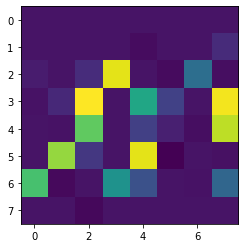

In [67]:
plt.imshow(test['X'][0][::6][:-3].reshape(8,8))

In [53]:
show_accuracy(final_theta, X, y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       182
           1       1.00      1.00      1.00       177
           2       0.99      1.00      0.99       183
           3       0.99      1.00      1.00       181
           4       1.00      1.00      1.00       182
           5       1.00      0.99      0.99       181
           6       0.99      1.00      0.99       179
           7       0.99      0.99      0.99       174
           8       1.00      0.98      0.99       180
           9       1.00      1.00      1.00       178

   micro avg       1.00      1.00      1.00      1797
   macro avg       1.00      1.00      1.00      1797
weighted avg       1.00      1.00      1.00      1797
 samples avg       1.00      1.00      1.00      1797



# Show the hidden layer

In [77]:
def plot_hidden_layer(theta):
    """
    theta: (size, )
    """
    final_theta1, _ = deserialize(theta, theta_dimensions)
    hidden_layer = final_theta1[:, 1:]  # ger rid of bias term theta

    fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(5, 5))

    for r in range(5):
        for c in range(5):
            ax_array[r, c].matshow(hidden_layer[5 * r + c].reshape((8, 8)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))


# nn functions starts here ---------------------------
# ps. all the y here is expanded version (5000,10)

In [117]:
final_theta = fmin.x

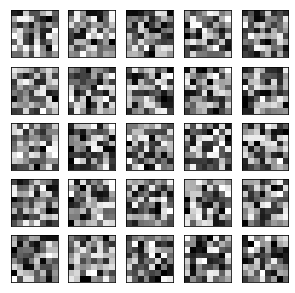

In [118]:
plot_hidden_layer(final_theta)
plt.show()